In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

In [4]:
from tensorflow.keras import layers,losses,metrics,optimizers

In [5]:
#样本数量
n = 400

In [6]:
# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

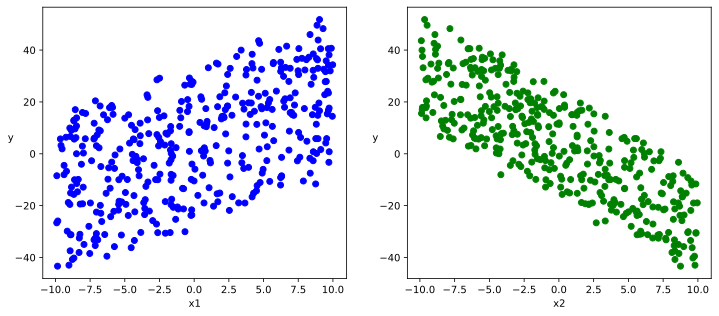

In [7]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [8]:
#构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 100).batch(10) \
     .prefetch(tf.data.experimental.AUTOTUNE)  

In [10]:
next(iter(ds))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 3.3852816 , -9.8461485 ],
        [-6.0166883 ,  4.6416874 ],
        [ 0.26807308,  6.1463203 ],
        [-8.6657095 ,  9.638645  ],
        [-7.392795  , -3.3052492 ],
        [ 9.882565  , -5.7346964 ],
        [ 6.9189167 , -4.570327  ],
        [-5.941286  , -1.9507504 ],
        [ 9.484051  ,  6.079071  ],
        [ 4.1157036 , -3.1349444 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 39.985344 ],
        [-24.258598 ],
        [-16.048756 ],
        [-40.22094  ],
        [ -2.6918442],
        [ 40.709312 ],
        [ 32.98228  ],
        [ -3.221003 ],
        [  4.1661077],
        [ 19.59177  ]], dtype=float32)>)

In [11]:
model = layers.Dense(units = 1) 
model.build(input_shape = (2,)) #用build方法创建variables
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

In [12]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.variables)
    model.optimizer.apply_gradients(zip(grads,model.variables))
    return loss

In [13]:
# 测试train_step效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=341.25525>

In [14]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss = tf.constant(0.0)
        for features, labels in ds:
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",model.variables[0])
            tf.print("b =",model.variables[1])

In [15]:
train_model(model,epochs = 200)

================================================================================10:57:33
epoch = 50 loss =  2.98739815
w = [[1.97263157]
 [-2.9820466]]
b = [3.00862]
================================================================================10:57:34
epoch = 100 loss =  3.53399014
w = [[1.97086918]
 [-2.984828]]
b = [3.0625639]
================================================================================10:57:35
epoch = 150 loss =  5.07759619
w = [[1.96987271]
 [-2.98982763]]
b = [3.06345987]
================================================================================10:57:36
epoch = 200 loss =  3.8165493
w = [[1.95644271]
 [-2.99165726]]
b = [3.06389499]


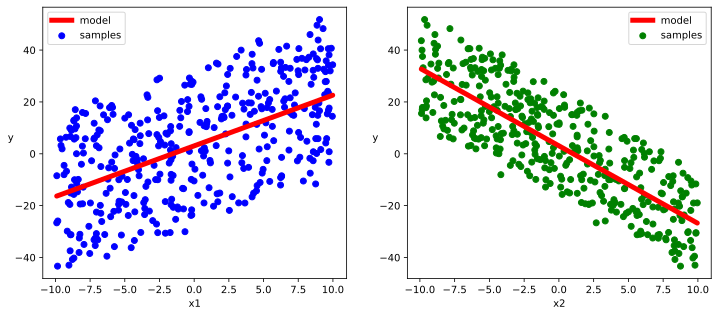

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

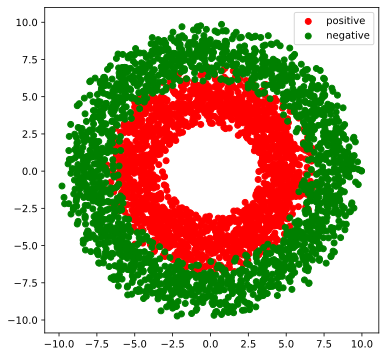

In [17]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [18]:
#构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 4000).batch(100) \
     .prefetch(tf.data.experimental.AUTOTUNE) 

In [19]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.dense1 = layers.Dense(4,activation = "relu") 
        self.dense2 = layers.Dense(8,activation = "relu")
        self.dense3 = layers.Dense(1,activation = "sigmoid")

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y

In [20]:
model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate=0.001)

In [21]:
# 测试模型结构
(features,labels) = next(ds.as_numpy_iterator())

predictions = model(features)

loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))
metric = model.metric_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 0.785319567
init metric 0.44


In [22]:
#使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    metric = model.metric_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    
    return loss,metric


In [23]:
# 测试train_step效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.76207507>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.52>)

In [24]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0),tf.constant(0.0)
        for features, labels in ds:
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)

In [25]:
train_model(model,epochs = 60)

================================================================================10:59:05
epoch = 10 loss =  0.571236253 accuracy =  0.71
================================================================================10:59:05
epoch = 20 loss =  0.404048 accuracy =  0.88
================================================================================10:59:06
epoch = 30 loss =  0.275664032 accuracy =  0.96
================================================================================10:59:06
epoch = 40 loss =  0.224200845 accuracy =  0.94
================================================================================10:59:06
epoch = 50 loss =  0.214059651 accuracy =  0.92
================================================================================10:59:06
epoch = 60 loss =  0.1896016 accuracy =  0.93


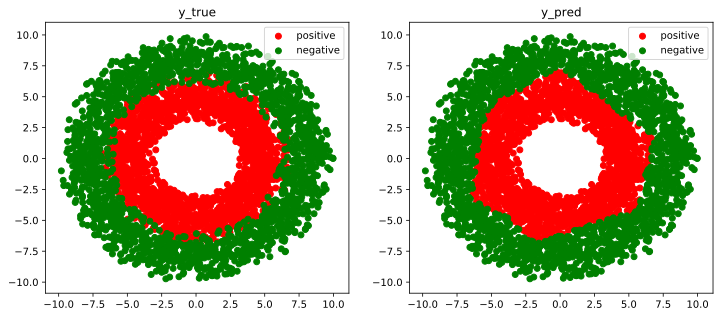

In [26]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

In [27]:
ds.as_numpy_iterator()

In [28]:
next(ds.as_numpy_iterator())

(array([[ 4.8471036 ,  4.8956404 ],
        [-4.347375  , -0.53664774],
        [ 3.1471372 , -0.56115466],
        [ 6.2709694 ,  4.6270022 ],
        [ 1.7011676 ,  9.330785  ],
        [ 7.210571  ,  4.7131286 ],
        [-5.5809474 ,  4.9235005 ],
        [ 4.9100847 , -2.3449955 ],
        [ 2.3927102 , -4.9684386 ],
        [ 3.2272184 ,  3.3410127 ],
        [-4.0699186 ,  0.70534986],
        [ 2.6623292 ,  3.8657699 ],
        [-4.151924  ,  6.1870527 ],
        [ 3.3464115 ,  5.3521676 ],
        [ 4.57659   ,  2.3950741 ],
        [-5.950595  , -5.2538996 ],
        [-3.3236287 , -3.5158486 ],
        [-4.8217835 , -5.445966  ],
        [ 9.074911  ,  0.04722083],
        [-8.383371  , -0.05931467],
        [ 1.2513962 , -7.3490796 ],
        [-1.5388305 , -6.843331  ],
        [-1.2428663 , -9.565482  ],
        [-3.0949667 , -3.1269414 ],
        [ 1.8044387 ,  4.4968553 ],
        [ 0.28722978, -4.884172  ],
        [ 4.5876565 , -0.9293269 ],
        [-2.0074544 ,  8.522